# Описание проекта

В нашем распоряжении данные от компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — **какой тариф лучше**.

# Оглавление

* [Описание данных](#description)
  * [Описание тарифов](#tariffs_descriptions)
* [Открытие и изучение файлов с данными](#data_exploration)
  * [Таблица о тарифах](#tariffs)
  * [Таблица о пользователях](#users)
  * [Таблица о звонках](#calls)
  * [Таблица о сообщениях](#messages)
  * [Таблица об интернес-сессиях](#internet)
* [Вывод](#summary_1)
* [Подготовка данных](#data_preparation)
  * [Предобработка данных](#data_preprocessing)
  * [Формирование дополнительных данных](#working_with_data)
    * [Объем израсходованных услуг для каждого пользователя по месяцам](#tariff_spent)
    * [Вычисление помесячной выручки с каждого пользователя](#users_revenue)
    * [Вывод](#summary_2)
* [Анализ данных](#data_analysis)
  * [Средний показатель по услугам тарифного пакета](#tariff_median)
  * [Median, var, std](#med_var_std)
  * [Гистограммы и распределения](#hist_dist) 
* [Вывод](#summary_3)
* [Проверка гипотез](#hypothesis_testing)
  * [Гипотеза_1](#hypothesis_1)
  * [Гипотеза_2](#hypothesis_2)
* [Вывод](#summary_4)
* [Общий вывод](#conslusion)

***Описание таблиц:*** <a id='datasets_descriptions'> </a>

**`Таблица tariffs (информация о тарифах)`**:

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**`Таблица users (информация о пользователях)`**:

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

**`Таблица calls (информация о звонках)`**:

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**`Таблица messages (информация о сообщениях)`**:

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**`Таблица internet (информация об интернет-сессиях)`**:

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

*Описание тарифов:* <a id='tariffs_descriptions'></a>

**`Тариф «Смарт»`**

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
  * минута разговора: 3 рубля
  * сообщение: 3 рубля
  * 1 Гб интернет-трафика: 200 рублей

**`Тариф «Ультра»`**

* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
  * минута разговора: 1 рубль
  * сообщение: 1 рубль
  * 1 Гб интернет-трафика: 150 рублей

**Обратим внимание**: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

## Открытие и изучение файлов с данными <a id='data_exploration'></a>

Откроем файлы и изучим общую информацию. 

Для начала импортируем необходимые для работы библиотеки:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats as st
from functools import reduce
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import Button 
import warnings
warnings.filterwarnings("ignore")

Прочитаем имеющие файлы:

In [2]:
users=pd.read_csv('users.csv') 

In [3]:
tariffs=pd.read_csv('tariffs.csv')

In [4]:
calls=pd.read_csv('calls.csv') 

In [5]:
messages=pd.read_csv('messages.csv') 

In [6]:
internet=pd.read_csv('internet.csv') 

Рассмотрим датасеты по очереди.

**[1] Таблица о тарифах** <a id='tariffs'></a>

In [7]:
tariffs.head() 

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [8]:
tariffs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


С данными все в порядке, пропусков и аномалий нет. 

**[2] Таблица о пользователях** <a id='users'></a>

In [9]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [10]:
users.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Проверим, есть ли дубликаты.

In [11]:
users.duplicated().sum() 

0

* Дубликатов нет.

* Имеем большое число пропусков в колонке *'churn_date'*. Причина пропусков - тариф ещё действовал на момент выгрузки данных. Данный столбец не используется в анализе. Поэтому оставим всё без изменений.

* Необходимо изменить типа данных *'reg_date'* с object на datetime.

* Также надо изменить название столбца *'tariff'* на *'tariff_name'*. Это будет необходимо при объединении таблиц. 

**[3] Таблица о звонках** <a id='calls'></a>

In [12]:
calls.head() 

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [13]:
calls.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Столбец *'duration'* один из основных для исследования. Посмотрим на его статистику:

In [14]:
calls[['duration']].describe() 

,duration
count,202607.000000
mean,6.755887
std,5.843365
min,0.000000
25%,1.300000
50%,6.000000
75%,10.700000
max,38.000000


Имеем нулевую длительность звонков. Судя по всему, это входящие/исходящие пропущенные/неотвеченные звонки. 

Выясним минимальный по длительности зафиксированный звонок. Посмотрим на срез данных от 0 до 1 минуты с сортировкой по возрастанию:

In [15]:
calls.query('1 > duration > 0')['duration'].sort_values() 

169056    0.01
155792    0.01
196972    0.01
199992    0.01
71994     0.01
          ... 
192884    0.99
31478     0.99
130329    0.99
1649      0.99
47075     0.99
Name: duration, Length: 8314, dtype: float64

Связь фиксируется даже в случае продолжительности звонка 0.01 минуты. Значит, '0' служит показателем, указывающим на несостоявшееся соединение. 

Вычислим число 'нулевых' звонков: 

In [16]:
calls[calls['duration'] == 0].count()[0] 

39613

Доля "нулевых" звонков составляет примерно 20% от общей выборки, что довольно много. Тем не менее, так как эти звонки не состоялись и не имеют даже околонулевого значения, оставим данные без изменений. Пусть нули остаются нулями - так устроена мобильная связь и таковы условия. Округление в большую сторону происходит только при значениях больше нуля.

В таблице есть атрибут *'call_date'* и его нужно преобразовать из object в dataframe. 

В остальном таблица выглядит нормально. 

**[4] Таблица о сообщениях** <a id='messages'></a>

In [17]:
messages.head() 

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [18]:
messages.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


С таблицей все в порядке. Необходимо только произвести изменение типа данных в колонке *'message_date'*.

**[5] Таблица об интернет-сессии** <a id='internet'></a>

In [19]:
internet.head() 

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [20]:
internet.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Столбец *'mb_used'* один из основных для исследования. Посмотрим на его статистику:

In [21]:
internet[['mb_used']].describe() 

,mb_used
count,149396.000000
mean,370.192426
std,278.300951
min,0.000000
25%,138.187500
50%,348.015000
75%,559.552500
max,1724.830000


Имеем нулевой объем использованного трафика. Судя по всему, это сбои при выходе в интернет. 

Выделим срез от 0 до 1 объема Мб с сортировкой по возрастанию:

In [22]:
internet.query('1 > mb_used > 0')['mb_used'].sort_values() 

15944     0.03
85722     0.04
108198    0.06
11027     0.07
11399     0.07
          ... 
55902     0.93
1593      0.93
11618     0.95
30493     0.96
59711     0.97
Name: mb_used, Length: 101, dtype: float64

Факт выхода в интернет фиксируется даже в случае использования совсем небольшого объема - 0.03 Мб. Значит, как и в случае со звонками, '0' - значемый показатель: попытка выхода в интернет была, но связь оборвалась. 

Вычислим число таких случаев:

In [23]:
internet[internet['mb_used'] == 0].count()[0] 

19598

Почти 16% случаев выхода в интернет являются несостоявшимися. Причины могут быть совершенно разными. Это и сбои в работе системы Мегалайн из-за внутренних проблем. Или внешние факторы: пользователь оказался вне зоны действия сети, разрядился телефон и т.д. Тем не менее, если выход в интернет не получился, объем трафика не зайдействован - оставляем нули нулями. 

Также, как и в других таблицах, необходимо привести данные колонки *'session_date'* к типу dataframe. В остальном все нормально.  

# Вывод <a id='summary_1'></a>

[1] `Пропуски`. 
Пропущенные значения встречаются только в датасете *users* колонке *'churn_date'*. Пропуски связаны с тем, что абонент продолжал использовать тариф на момент выгрузки данных. Оставляем данные без изменений.

[2] `Нулевые значения`.
Есть нулевые значения в категории 'длительность звонков' и объему использованного интернета - сохраняем нули как показатель несостоявшегося соединения.

[3] `Округление данных`.
Согласно условиям тарифа длительность звонков и объем трафика округляются в большую сторону. Поэтому необходимо произвести подобные изменения.

[4] `Изменение типа данных`.
Меняем тип данны в колонках с датами: *'reg_date'*, *'call_date'*, *'message_date'*, *'session_date'*.

[5]`Изменение названия колонки`. В таблицах **tariffs** и **users** есть столбец с определением тарифа. В одном случае он имеет название *'tariff_name'*, в другом - *'tariff'* соответственно. Нужно переименовать одну из колонок, чтобы не допустить сбоя при объединении данных. 

## Подготовка данных <a id='data_preparation'></a>

Небольшое отступление. 

В процессе работы над проектом появится необходимость возвращаться к параметрам тарифных планов. Создадим для удобства кнопку, которая выведит нужные параметры. Добавим кнопку в те разделы исследования, где это необходимо.

In [24]:
button = Button(description="Тариф",button_style='info') 

def on_button_clicked(b): 
    print(tariffs)

button.on_click(on_button_clicked) 

Теперь перейдем к предподготовке данных.

При подготовке к анализу первым делом откорректируем данные, а затем создадим новые столбцы с дополнительными сведениями, которые будем использовать в исследовании.

**[1] Предобработка данных** <a id='data_preprocessing'></a>

* `Изменение типа данных` 

Приведем данные *'reg_date', 'call_date', 'message_date', 'session_date'* к нужному типу с помощью модуля *datetime*:

In [25]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Проверим результат:

In [26]:
calls.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Все в порядке. Двигаемся дальше.

* `Округление данных`

Округлим длительность звонков и объем интернета до целых чисел. 

Согласно условиям тарифов минуты и Мб округляются в большую сторону. Применим функцию *ceil()* для массива *'duration'* и *'mb_used'* и преобразуем к целочисленному типу.  

In [27]:
calls['duration'] = (np.ceil(calls[['duration']])).astype('int')
internet['mb_used'] = (np.ceil(internet[['mb_used']])).astype('int')

* `Изменение названия колонки`

Изменим название колонки в *'tariff'* на *'tariff_name'* в датасете **users**:

In [28]:
users.rename(columns={'tariff':'tariff_name'}, inplace=True) 
users.columns 

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff_name'],
      dtype='object')

Предобработка данных выполнена. Можем переходить к дальнешей работе.

**[2] Формирование дополнительных данных** <a id='working_with_data'></a>

Выполним следующие действия:

1. Посчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений и объем израсходованного интернет-трафика по месяцам; 

2. Вычислим помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану.

* **Объем израсходованных услуг для каждого пользователя по месяцам.** <a id='tariff_spent'></a>

Итак, определяем количество израсходованных минут, смс и интернета.

Сначала создадим столбец *'month'* для датасетов **calls, messages, internet**:

In [29]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

Сформируем таблицы расхода звонков, смс и интернета по месяцам:

In [30]:
# формирование датасета calls_by_month по длительности звонков по месяцам

calls_by_month = calls.pivot_table(index=['user_id','month'], values='duration',aggfunc=['count','sum'])
calls_by_month.reset_index(inplace=True) 
calls_by_month.columns=['user_id', 'month', 'month_calls','month_duration']
calls_by_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   user_id         3174 non-null   int64
 1   month           3174 non-null   int64
 2   month_calls     3174 non-null   int64
 3   month_duration  3174 non-null   int32
dtypes: int32(1), int64(3)
memory usage: 86.9 KB


In [31]:
# формирование датасета messages_by_month по объему числа смс по месяцам

messages_by_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
messages_by_month.reset_index(inplace=True)                   
messages_by_month.rename(columns={'id':'month_sms'}, inplace=True)
messages_by_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id    2717 non-null   int64
 1   month      2717 non-null   int64
 2   month_sms  2717 non-null   int64
dtypes: int64(3)
memory usage: 63.8 KB


In [32]:
# формирование датасета internet_by_month по объему интернет-трафика по месяцам

internet_by_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used',aggfunc='sum')
internet_by_month.reset_index(inplace=True)
internet_by_month.rename(columns={'mb_used':'month_mb'}, inplace=True)
internet_by_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   user_id   3203 non-null   int64
 1   month     3203 non-null   int64
 2   month_mb  3203 non-null   int32
dtypes: int32(1), int64(2)
memory usage: 62.7 KB


Объединим все полученные таблицы в одну *data_month*:

In [33]:
# сгенерируем список полученных таблиц 

data = [calls_by_month, messages_by_month, internet_by_month] 

# создаем объединенную таблицу 

data_month = reduce(lambda  left, right: pd.merge(left,right, on=['user_id','month'], how='outer'), data)
data_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   month_calls     3174 non-null   float64
 3   month_duration  3174 non-null   float64
 4   month_sms       2717 non-null   float64
 5   month_mb        3203 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 175.8 KB


Добавим названием тарифа к полученной таблице и выведим результат на экран:

In [34]:
data_month = data_month.merge(users[['user_id', 'tariff_name']], on='user_id', how='outer')
data_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3216 non-null   int64  
 1   month           3214 non-null   float64
 2   month_calls     3174 non-null   float64
 3   month_duration  3174 non-null   float64
 4   month_sms       2717 non-null   float64
 5   month_mb        3203 non-null   float64
 6   tariff_name     3216 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 201.0+ KB


В сформированной таблице есть пропуски, что вполне объяснимо. Есть пользователи, которые в течение месяца не совершали звонков, не отправляли смс или не пользовались интернетом. Больше всего пропусков в количестве смс. А вот интернет остается неиспользованным намного реже. 

Оставлять пропуски не стоит. Заполним их нулями:

In [35]:
data_month = data_month.fillna(0) 
data_month.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3216 non-null   int64  
 1   month           3216 non-null   float64
 2   month_calls     3216 non-null   float64
 3   month_duration  3216 non-null   float64
 4   month_sms       3216 non-null   float64
 5   month_mb        3216 non-null   float64
 6   tariff_name     3216 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 201.0+ KB


Пропуски заполнены, все в порядке. 

Переходим к пункту 2. 

* **Вычисление помесячной выручки с каждого пользователя.** <a id='users_revenue'></a>

Добавим параметры тарифов к нашей таблице **data_month**:

In [36]:
data_month = data_month.merge(tariffs, on='tariff_name', how='outer')

Создадим функцию подсчета переплат пользователей по месяцам. Учтем, что в тариффах указана сумма переплаты за 1 Гб, а данные пользователей выводятся в мегабайтах. 

In [37]:
def overpaiment(row):
    duration = (row['month_duration'] - row['minutes_included']) * row['rub_per_minute']
    message = (row['month_sms'] - row['messages_included']) * row['rub_per_message']
    internet = (row['month_mb'] - row['mb_per_month_included']) * (row['rub_per_gb'] / 1024) 
    total = 0
    for i in [duration, message, internet]:
        if i > 0:
            total += i 
    return total

Создадим новый столбец *'overpaiment'* и включим его в *data_month*:

In [38]:
data_month['overpaiment'] = round(data_month.apply(lambda x: overpaiment(x), axis=1))

И, наконец, создадим столбец выручки *'revenue'*, приписав ему суммы ежемесячных переплат и абонентской платы для каждого пользователя:

In [39]:
data_month['revenue'] = round(data_month['overpaiment'] + data_month['rub_monthly_fee'])

Выведим на экран несколько наиболее информативных столбцов полученной таблицы, выстроив значения выручки по убыванию:

In [40]:
data_month[['user_id', 'month', 'month_calls', 'month_duration', 'month_sms', 'month_mb', 'overpaiment', 'revenue', 'tariff_name']].sort_values(by='revenue', ascending=False).head()

,user_id,month,month_calls,month_duration,month_sms,month_mb,overpaiment,revenue,tariff_name
3158,1486,12.0,133.0,1007.0,83.0,38610.0,6161.0,6711.0,smart
2178,1261,12.0,141.0,1074.0,22.0,32697.0,5108.0,5658.0,smart
1184,1042,12.0,121.0,728.0,75.0,37219.0,5028.0,5578.0,smart
3157,1486,11.0,108.0,764.0,96.0,36319.0,5024.0,5574.0,smart
2299,1286,12.0,95.0,739.0,68.0,35151.0,4636.0,5186.0,smart


In [41]:
display(button)

Button(button_style='info', description='Тариф', style=ButtonStyle())

Видим, что верхние строки заняли абоненты "Смарт" с довольно большой суммой переплат. В некоторых случаях объем израсходованных ими услуг превышет даже пакет "Ультра". Ну, что же, активные пользователи вносят бóльший вклад в доход компании.

Посмотрим, как распределяются переплаты пользователей разных тарифов. 

In [42]:
# число случаев переплаты у пользователей тарифа "Смарт"

len(data_month.loc[(data_month['overpaiment'] > 0) & (data_month['tariff_name'] == 'smart')])

1665

In [43]:
# число случаев переплаты у пользователей тарифа  "Ультра"

len(data_month.loc[(data_month['overpaiment'] > 0) & (data_month['tariff_name'] == 'ultra')])

134

Чаще всего переплаты наблюдаются у пользователей тарифов "Смарт". Это вполне понятно, так как разница в пакетах включенных минут, смс и интернет трафика разительно отличается для обоих тарифов.

# Вывод <a id='summary_2'></a>

Мы произвели замену типов данных, округлили значения длительности звонков и объема использованного интернета в большую сторону, заменили название столбца в таблице **users**, сформировали таблицу **data_month** со сгруппированными по месяцам данными и вычислили выручку с каждого пользователя в месяц. Можем приступать к анализу данных.

## Анализ данных <a id='data_analysis'></a>

Наща задача - описать поведение клиентов оператора, исходя из выборки. 

**[1] Средний показатель по услугам тарифного пакета.** <a id='tariff_median'></a>

Вычислим сколько в среднем минут разговора, количетсво сообщений и объём интернет-трафика требуется пользователям каждого тарифа в месяц. 


Сформируем новую таблицу *data_median* с данными средних значений по требуемым выборкам:

In [44]:
data_median = data_month.pivot_table(index='user_id', values=['month_duration', 'month_sms', 'month_mb'], aggfunc='median')

Добавим столбец с названием тарифа:

In [45]:
data_median = data_median.merge(users[['user_id', 'tariff_name']], on = 'user_id', how='outer')

Посмотим на таблицу, сортировав значения параметру длительности звонков:

In [46]:
data_median.sort_values(by='month_duration', ascending=False).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 377 to 328
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         500 non-null    int64  
 1   month_duration  500 non-null    float64
 2   month_mb        500 non-null    float64
 3   month_sms       500 non-null    float64
 4   tariff_name     500 non-null    object 
dtypes: float64(3), int64(1), object(1)
memory usage: 23.4+ KB


In [47]:
display(button)

Button(button_style='info', description='Тариф', style=ButtonStyle())

Верхние строки выборки заняли абоненты "Ультра". И даже при этом они расходуют в среднем только треть предоставленного им пакета минут. Явно переплачивают.

**[2] Median, var, std.** <a id='med_var_std'></a>

Теперь вычислим среднее количество, дисперсию и стандартное отклонение для каждой из услуг тарифных пакетов. 

In [48]:
data_calls_stat = data_median.pivot_table(index='tariff_name', values='month_duration', aggfunc=['median','mean', 'var', 'std']) 
data_calls_stat.columns=['calls_median', 'calls_mean', 'calls_var', 'calls_std']
data_calls_stat.round(2)

,calls_median,calls_mean,calls_var,calls_std
tariff_name,,,,
smart,439.5,436.22,26157.24,161.73
ultra,533.5,553.76,93752.96,306.19


In [49]:
display(button)

Button(button_style='info', description='Тариф', style=ButtonStyle())

Пользователи тарифа "Смарт", как правило, исчерпывающе расходуют пакет минут и нередко выходят за его рамки. В то время, как пользователи тарифа "Ультра", как правило, остаются в рамках положенных в тарифе объема минут и еще сохраняют довольно большой запас к концу расчетного периода. 

In [50]:
data_sms_stat = data_median.pivot_table(index='tariff_name', values='month_sms', aggfunc=['median', 'var', 'std']) 
data_sms_stat.columns=['sms_median', 'sms_var', 'sms_std']
data_sms_stat.round(2)

,sms_median,sms_var,sms_std
tariff_name,,,
smart,28.5,785.60,28.03
ultra,47.5,2429.68,49.29


In [51]:
display(button)

Button(button_style='info', description='Тариф', style=ButtonStyle())

Видим, что в среднем пользователи "Смарт" склонны незначительно превышать расход смс, включенных в ежемесячный пакет. Абоненты другого тарифа, хотя и отправляют сообщения в два раза чаще, тем не менее, оставляют неиспользованными почти 90% влюченных в тариф смс.

In [52]:
data_internet_stat = data_median.pivot_table(index='tariff_name', values='month_mb', aggfunc=['median', 'var', 'std']) 
data_internet_stat.columns=['mb_median', 'mb_var', 'mb_std']
data_internet_stat.round(2)

,mb_median,mb_var,mb_std
tariff_name,,,
smart,16935.0,18227930.63,4269.42
ultra,19675.0,81467297.18,9025.92


In [53]:
display(button)

Button(button_style='info', description='Тариф', style=ButtonStyle())

Абоненты "Смарт" в используют 16,5 ± 4 Гб, т.е. бывают случаи выхода за рамки включенного в тариф объема интернета. Пользователи тарифа "Смарт" отражают больший разброс значений: при использовании в среднем 19 ± 8,7 Гб интернета в месяц, таким образом, неисчерпывая ежемесячный трафик.  

**[3] Гистограммы, графики и распределения.** <a id='hist_dist'></a> 

Построим гистограммы для каждой из услуг тарифных пакетов и опишем полученные распределения. Для проверки нормальности распределения дополнительно построим графики квантилей.

### Исследования длительности звонков

In [54]:
smart_duration = data_median[data_median['tariff_name'] == 'smart']['month_duration'] #данные по тарифу смарт
ultra_duration = data_median[data_median['tariff_name'] == 'ultra']['month_duration'] #данные по тарифу ультра

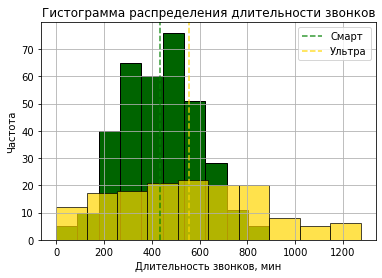

In [55]:
smart_duration.plot(kind='hist', grid=True, color='darkgreen', edgecolor='black')
ultra_duration.plot(kind='hist', grid=True, color='gold', edgecolor='black', alpha=0.7)

plt.axvline(smart_duration.mean(), color='green', alpha=0.8, linestyle='dashed')
plt.axvline(ultra_duration.mean(), color='gold', alpha=0.8, linestyle='dashed')

plt.title('Гистограмма распределения длительности звонков')
plt.xlabel('Длительность звонков, мин')
plt.ylabel('Частота')
plt.legend(['Смарт', 'Ультра']);

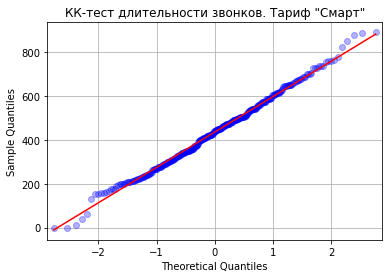

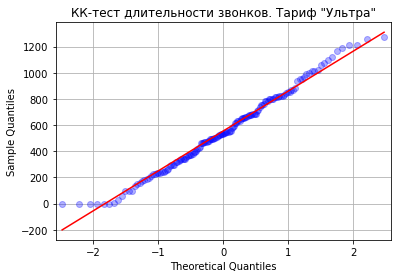

In [56]:
# КК график с выборкой по числу длительности звонков

sm.qqplot(data_median[data_median['tariff_name']=='smart']['month_duration'], line = 's',  alpha=0.3)
plt.title('КК-тест длительности звонков. Тариф "Смарт"')
plt.grid(True)

sm.qqplot(data_median[data_median['tariff_name']=='ultra']['month_duration'], line = 's',  alpha=0.3)
plt.title('КК-тест длительности звонков. Тариф "Ультра"')
plt.grid(True);

Распределение данных по двум тарифам отличается. Значения "Смарта" значительно больше тяготеет к нормальнумо, практически Пуассоновскому распределению. Разброс значений "Ультра" значительно шире.

Как подтверждают графики квантилей, наши данные не имеют серьезных отклонений от теоретического нормального распределения.

### Исследования количества смс

In [57]:
smart_sms = data_median[data_median['tariff_name'] == 'smart']['month_sms'] #данные по тарифу смарт
ultra_sms = data_median[data_median['tariff_name'] == 'ultra']['month_sms'] #данные по тарифу ультра

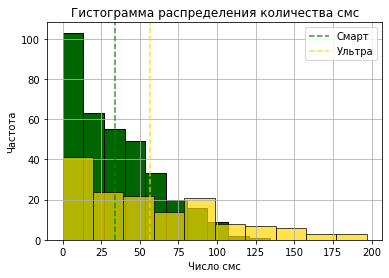

In [58]:
# гистограмма распределения количетсва смс

smart_sms.plot(kind='hist', grid=True, color='darkgreen', edgecolor='black')
ultra_sms.plot(kind='hist', grid=True, color='gold', edgecolor='black', alpha=0.7)

plt.axvline(smart_sms.mean(), color='green', alpha=0.8, linestyle='dashed')
plt.axvline(ultra_sms.mean(), color='gold', alpha=0.8, linestyle='dashed')

plt.title('Гистограмма распределения количества смс')
plt.xlabel('Число смс')
plt.ylabel('Частота')
plt.legend(['Смарт', 'Ультра']);

Бросается в глаза огромное количество нулевых значений. Оба датасета сильно скошены вправо, т.е. имеют ярко выраженную положительную скошенностью. Распределение данных по двум тарифам отличается, что особенно заметно на данных "Ультра". Судя по всему, стремление к "нормальности" находится на полпути )). 

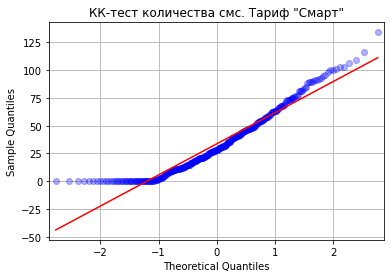

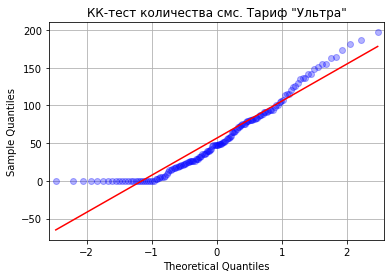

In [59]:
# КК график с выборкой по числу смс

sm.qqplot(data_median[data_median['tariff_name']=='smart']['month_sms'], line = 's',  alpha=0.3)
plt.title('КК-тест количества смс. Тариф "Смарт"')
plt.grid(True)

sm.qqplot(data_median[data_median['tariff_name']=='ultra']['month_sms'], line = 's',  alpha=0.3)
plt.title('КК-тест количества смс. Тариф "Ультра"')
plt.grid(True);

График вторит гистограмме - нормальным это распределение назвать сложно, отклонения слева - наши бесчисленные нули. Некоторая доля выбросов у правого хвоста.

### Исследования трафика

In [60]:
smart_mb = data_median[data_median['tariff_name'] == 'smart']['month_mb'] #данные по тарифу смарт
ultra_mb = data_median[data_median['tariff_name'] == 'ultra']['month_mb'] #данные по тарифу ультра

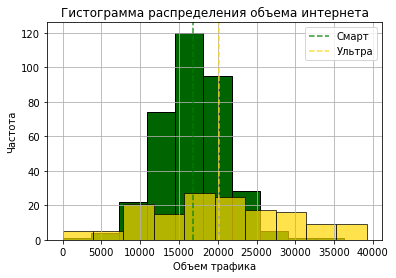

In [61]:
# гистограмма распределения объема интернета

smart_mb.plot(kind='hist', grid=True, color='darkgreen', edgecolor='black')
ultra_mb.plot(kind='hist', grid=True, color='gold',edgecolor='black', alpha=0.7)

plt.axvline(smart_mb.mean(), color='green', alpha=0.8, linestyle='dashed')
plt.axvline(ultra_mb.mean(), color='gold', alpha=0.8, linestyle='dashed')

plt.title('Гистограмма распределения объема интернета')
plt.xlabel('Объем трафика')
plt.ylabel('Частота')
plt.legend(['Смарт', 'Ультра']);

С интернетом ситуация напоминает минуты звонков: данные "Смарт" - почти что "колокол", "Ультра" к этому тяготеет, но и разброс шире и мода выражена хуже. 

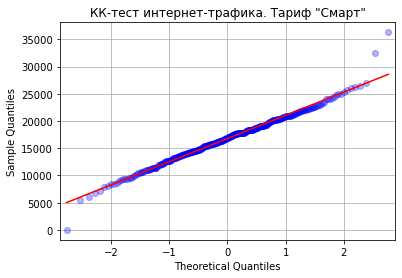

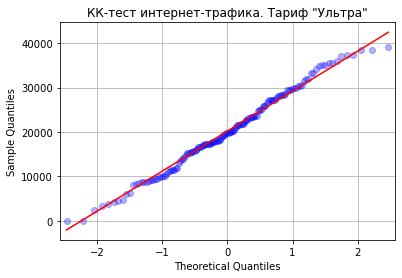

In [62]:
# КК график с выборкой по объему интернета

sm.qqplot(data_median[data_median['tariff_name']=='smart']['month_mb'], line = 's',  alpha=0.3)
plt.title('КК-тест интернет-трафика. Тариф "Смарт"')
plt.grid(True)

sm.qqplot(data_median[data_median['tariff_name']=='ultra']['month_mb'], line = 's',  alpha=0.3)
plt.title('КК-тест интернет-трафика. Тариф "Ультра"')
plt.grid(True);

Графики квантилей позволяют утверждать, что данные имеют нормальное распределение, хотя и заметны выбросы. Куда же без них.

Подведем итог.

Визуазилация данных подтвердила значения дисперсии и среднего отклонения: дисперсия на "Смарт" заметно меньше, чем у абонентов "Ультра", что особенно видно по звонкам и интернету. В свою очередь, смс оказались наименее востребованным способом общения - весомая часть собрана вначале гистограммы - нулевое и околонулевое распределение. 

Графики в основном отражают приближение данных к нормальному распределению для звонков и интернета, но не для смс. 

Дополнительно посмотрим, сколько пользователей выходят за рамки свомх тарифов:

In [63]:
# общее число внепакетных переплат для тарифа "Смарт"

smart = len(data_median.query('month_duration > 500 or month_sms > 50 or month_mb > 15360'))
smart

423

In [64]:
# общее число внепакетных переплат для тарифа "Смарт"

ultra = len(data_median.query('month_duration > 3000 or month_sms > 1000 or month_mb > 30720'))
ultra

20

In [65]:
display(button)

Button(button_style='info', description='Тариф', style=ButtonStyle())

418 из 500 пользователям "Смарт" в том или ином месяце не хватало минут, смс или интернета, включенных в тарифный план. В сравнении: только 20 абонетов "Ультра" превысили один из параметров тарифа.

# Вывод

**Визуализация**:

Гистограммы и КК-графики показали, что звонки и интернет не имеют серьезных отклонений от теоретического нормального распределения и стремяться к нему. А вот область смс-значений имеет ярко выраженную положительную ассиметрию и распределение выглядит ненормальным.  

Что касается дисперсии, то она заметна шире у тарифа "Ультра" по всем услугам пакета: звонкам, смс и интернету. 


**Характеристика пользователей:**

Полученные результаты показывают, что абоненты "Смарт" хотя и стремятся не выходить за рамки объема минут, смс и интернет-трафика, включенных в тариф, очень часто превышают лимит, и это заставляет их вносить дополнительную плату. 

Абоненты более дорогого тарифа "Ультра", напротив, не только не ужимают себя, но и часто не расходуют всего положенного объема к концу расчетного периода.

## Проверка гипотез <a id='hypothesis_testing'></a>

В рамках данного проекта нам необходимо выяснить:

1. Есть ли зависимость между тарифом и средней выручкой;
2. Если ли зависимость между тарифом и городом абонента.

Имея две выборки с данными, стремящимися к нормальному распределению , мы можем выяснить, является ли разница между этими выборками случайной или нет. Для этого будем использовать статистический критерий Стьюдента. 

**Гипотеза 1** - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается. <a id='hypothesis_1'></a>

Посмотрим на дисперсию и стандартное отклонение обеих выборок:

In [66]:
data_tariff_var = round(data_month.pivot_table(index='tariff_name', values=['revenue'], aggfunc='var'))
data_tariff_var

,revenue
tariff_name,
smart,620389.0
ultra,126827.0


Дисперсии значительно отличаются, что необходимо учесть в проводимом тесте.

Предположем наиболее очевидный вариант, что тариф влияет на сумму выручки и, следовательно, средняя выручка на разных тарифах различается. 

Для проверки используем H₀ - нулевую гипотезу для средних данных - *гипотеза равенства*. 

*Альтернативная гипотеза,* H₁, должна подтвердить или опровергнуть факт влияние тарифа на выручку.

H₀  — средняя выручка пользователей тарифа "Смарт" и "Ультра" равны; 

H₁ — средняя выручка пользователей тарифов "Смарт" и "Ультра" различаются.

Для проверки гипотезы используем метод ttest_ind из пакета scipy.stats.
Уровень значимости устновим α=5%. Из-за различий в дисперсиях установим параметр equal_var=False (случай t-теста Уэлча).

In [67]:
smart = data_month.query('tariff_name == "smart"')['revenue']
ultra = data_month.query('tariff_name == "ultra"')['revenue']

alpha = .05

results = st.ttest_ind(
    smart,
    ultra,
    equal_var=False)
     
    

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.657624008634559e-296
Отвергаем нулевую гипотезу


Результат с практически 100% уверенностью позволил нам отвергнуть нулевую гипотезу. 

Посмотрим на различия в средней выручке и переплате по тарифу:

In [68]:
data_month.pivot_table(index='tariff_name', values=['overpaiment','revenue'], aggfunc=['sum','median'])

sum                 median        
            overpaiment    revenue overpaiment revenue
tariff_name                                           
smart         1523199.0  2749699.0       409.5   959.5
ultra          108872.0  2031572.0         0.0  1950.0

Проведенный статистический анализ позволил опровергнуть нулевую гипотезу, что подтверждает зависимость средней выручки от тарифа. И мы видим, что средние значения выручки по тарифам различаются более, чем в 2 раза. Тариф "Ультра" в среднем приносить 1950 руб в месяц от каждого пользователя. Тариф "Смарт" приносит в среднем выручку в 960 руб в ежемесячно.

Перейдем ко второй гипотезе:

**Гипотеза 2** - Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. <a id='hypothesis_2'></a>

Для проведения данного статистического анализа добавим столбец *'city'* к имеющейся таблице:

In [69]:
data_month = data_month.merge(users[['user_id', 'city']], on='user_id', how='left')

Теперь категоризируем города по группам: "Москва", "Другой регион":

In [70]:
# функция для формирование двух основных категорий регионов

def det_region(city):
    if city == 'Москва': 
        return 'Москва'
    else: 
        return 'Другой регион'

In [71]:
# формирование нового столбца 'region' с сгруппированными данными

data_month['region'] = data_month['city'].apply(det_region) 

Теперь посмотрим, каковы различия в дисперсиях:

In [72]:
data_region_var = round(data_month.pivot_table(index='region', values='revenue', aggfunc='var'))
data_region_var

,revenue
region,
Другой регион,630435.0
Москва,547245.0


Различия в данные не столь велики, как в выборкам по тарифам, но все же значимы. 

Перейдем к формулировке и проверке гипотез.

H₀  — средняя выручка пользователей из Москвы и других регионов равны.

H₁ — средняя выручка пользователей из Москвы других регионов различны. 

α=5%

equal_var=False

In [73]:
# Проверка гипотезы о зависимости средней выручки от города использования тарифа 

moscow = data_month.query('region == "Москва"')['revenue']
others = data_month.query('region != "Москва"')['revenue']

alpha = .05

results = st.ttest_ind(
    moscow, 
    others,
    equal_var=False)
        
   
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4516693741165556
Не получилось отвергнуть нулевую гипотезу


Как видим средняя выручка от трат на сотовую связь москвичей практически не отличаются от других населенных пунктов. Утверждай мы обратное, мы бы ошиблись с вероятностью 45%.

Посмотрим различия в средней переплате и выручке в зависимости от региона:

In [74]:
data_month.pivot_table(index='region', values=['overpaiment', 'revenue'], aggfunc=['sum','median'])

sum                 median        
              overpaiment    revenue overpaiment revenue
region                                                  
Другой регион   1362170.0  3860320.0       123.0  1518.0
Москва           269901.0   920951.0        49.0  1705.0

Действительно, различия в среднем значение выручки невелики. Поэтому выдвинутая изначально гипотеза о том, что Москва приносит Мегалайну больший доход, неверна. Каждый из абонентов Москвы в среднем  приносить 1705 руб дохода в месяц. Средняя выручка из других регионов составляет 1518 руб с одного клиента. Хотя отметим, что из предоставленной Мегалайн информации о 500 абонентах, только 99 являются Москвичами, 401 - живут в других регионах. И, как видим, это отразилось на общем доходе за 2018 год.

# Вывод <a id='summary_4'></a>

Мы выдвинуди две гипотезы: о влиянии тарифа и региона на доход Мегалайна. Первая гипотеза подтверлилась - тариф "Ультра" с большей абоненской платой и значительно большим объемом услуг приносит в среднем и больше ежемесячного дохода. 

Вторая гипотеза не подтвердилась. Явной зависимсти средней выручки от региона нет.

## Общий вывод <a id='conslusion'></a>

После проведенного исследования мы можем сделать следующие выводы:

[1] Средний ежемесячный доход Мегалайн от тарифа "Ультра" в два раза больше, чем от тарифа "Смарт".В среднем «Мегалайн» получает ежемесячно 960 руб от одного абонента "Смарт" и 1950 руб от "Ультра" - разница значительна - 990 руб. При этом доход от "Ультра" в основном формируется благодаря абонентской плате. В то время, как выручка от тарифа "Смарт" основана практически в равной мере на абонентской плате (46% выручки) и переплатах сверх объема предоставленных услуг (54% выручки). 

[2] Мегалайн получает в среднем примерно равный доход от пользователей Москвы и других регионов: 1705 руб от пользователя Москвы и 1518 руб от каждого из абонентов других регионов - разница незначительная 187 руб. Несмотря на это, из имеющейся у нас выборки 99 из 500 клиентов относятся к столичному региону. И, если количество абонентов в Москве увеличится, то и вероятность более высокой выручки от жителей столицы может возрасти. 

[3] Из 500 клиентов Мегалайн 341 подключены к "Смарт" и 149 к "Ультра". Абонентам "Смарт" часто не хватает включенного в тариф объема услуг и, они вынуждены переплачивать за дополнительные минуты, смс или интернет. В то время, как в тарифе "Ультра" остается большое количество неизрасходованного пакета. Мегалайну имеет смысл откорректировать тарифы, увеличив пакет услуг тарифа "Смарт", чтобы не упустить оттока клиентов, не готовых платить 1950 в месяц за сотовую связь. Вместе с тем, надо сократить пакет услуг в тарифе "Ультра", чтобы не тратить впустую большой объем включенных услуг и не терять вероятностный доход. 

В заключении ответим на главный вопрос: какой из тарифов лучше? 

С точки зрения дохода для компании выгоднее оказался тариф "Ультра". И все же, если посмотреть на общую сумму выручки за 2018 год, тариф "Смарт" принес Мегалайну 2749699 руб, "Ультра" - 2031572 руб. Разница составляет более 30%

В свою очередь для абонентов оба тарифа в различной степени не соответствует среднему потреблению: "Смарт" выглядит несколько тесным и в большей мере это касается интернета, в меньшей - смс. Тариф "Ультра" смотрится чересчур просторным, в особенности это касается количества смс, интернетом абонентны "Ультра" пользуется чаще.